<a href="https://colab.research.google.com/github/marcinwolter/Higgs_Janka/blob/main/Higgs_Janka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higgs analysis of Janka

author: Marcin Wolter, February 2021

In [13]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Read the cvs input data from google disk and create DataFrame

IMPORTANT: from background only a part of events is read (we read an equal number of signal and background events)

In [14]:
# Read csv data

from google.colab import drive
drive.mount('/content/drive')

masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]

bckg = []
sig = []
for i in range(len(masses)):
  bckg_str = '/content/drive/MyDrive/jkrzysiak/data/Ztautau_'+str(masses[i])+'GeV.csv'
  bckg.append(pd.read_csv(bckg_str) )
  sig_str = '/content/drive/MyDrive/jkrzysiak/data/signal_'+str(masses[i])+'GeV.csv'
  sig.append(pd.read_csv(sig_str) )


#print(bckg)

XX = []
YY = []
WEIGHT = []

for i in range(len(masses)):
  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']]
  xsw= sig[i][['weight']]
  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']] #.head(len(xs))
  xbw= bckg[i][['weight']] #.head(len(xs))
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["class"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["class"])

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  print(x.shape, y.shape, w.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1414396, 6) (1414396, 1) (1414396, 1)
(1425476, 6) (1425476, 1) (1425476, 1)
(1446300, 6) (1446300, 1) (1446300, 1)
(1461095, 6) (1461095, 1) (1461095, 1)
(1471361, 6) (1471361, 1) (1471361, 1)
(1483219, 6) (1483219, 1) (1483219, 1)
(1448090, 6) (1448090, 1) (1448090, 1)
(1447411, 6) (1447411, 1) (1447411, 1)
(1445797, 6) (1445797, 1) (1445797, 1)
(1414950, 6) (1414950, 1) (1414950, 1)
(1395065, 6) (1395065, 1) (1395065, 1)
(1384146, 6) (1384146, 1) (1384146, 1)
(1375814, 6) (1375814, 1) (1375814, 1)


Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 




In [15]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=6000000, shuffle=True, random_state=42)



(18613120, 6) (18613120, 1) (18613120, 1)


In [16]:
# Define normalization of input data
layer = preprocessing.Normalization()
layer.adapt(x_train_all.to_numpy())

Prepare a small fully connected network

In [17]:
# prepare keras model

def define_model():
  n_nodes = 64
  dropout = 0.05
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_shape=(6,)))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [19]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")
  #metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', # 'mse'
              optimizer='adam', #"sgd",
              metrics=[tf.keras.metrics.AUC(name='auc')])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1
  )

  epochs = 100
  batch_size=128
  print("fitting")
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[es])
  return history, model
#sample_weight = sw_train,

K-folding

In [20]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("fit_model")
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    loss, auc  = model.evaluate(testX, testY, verbose=0)
    print(loss, auc)
		# stores scores
    scores.append(loss)
    histories.append(history)
    models.append(model)

    # break the loop to avoid k-folding
    break

  return scores, histories, models

Plot learning curves and summary of training

In [21]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification AUC')
    plt.plot(histories[i].history['auc'], color='blue', label='train')
    plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [22]:
def network_fit(x_train_all, y_train_all, sw_train_all):


  #convert to numpy

  np_x_train_all = x_train_all.to_numpy()
  np_y_train_all = y_train_all.to_numpy()
  np_sw_train_all = sw_train_all.to_numpy()


  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  np_x_train_all = np.array(layer(np_x_train_all))

  # Train the network. 
  n_folds = 10  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [23]:
# train the network
scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

fit_model
compiling
fitting
Epoch 1/100
42188/42188 [==============================] - 138s 3ms/step - loss: 0.1605 - auc: 0.9188 - val_loss: 0.1520 - val_auc: 0.9296
Epoch 2/100
42188/42188 [==============================] - 136s 3ms/step - loss: 0.1525 - auc: 0.9287 - val_loss: 0.1505 - val_auc: 0.9313
Epoch 3/100
42188/42188 [==============================] - 135s 3ms/step - loss: 0.1518 - auc: 0.9298 - val_loss: 0.1502 - val_auc: 0.9322
Epoch 4/100
42188/42188 [==============================] - 135s 3ms/step - loss: 0.1505 - auc: 0.9318 - val_loss: 0.1485 - val_auc: 0.9344
Epoch 5/100
42188/42188 [==============================] - 135s 3ms/step - loss: 0.1496 - auc: 0.9330 - val_loss: 0.1488 - val_auc: 0.9344
Epoch 6/100
42188/42188 [==============================] - 135s 3ms/step - loss: 0.1491 - auc: 0.9335 - val_loss: 0.1471 - val_auc: 0.9356
Epoch 7/100
42188/42188 [==============================] - 135s 3ms/step - loss: 0.1490 - auc: 0.9337 - val_loss: 0.1475 - val_auc: 0.9349

Make plots

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


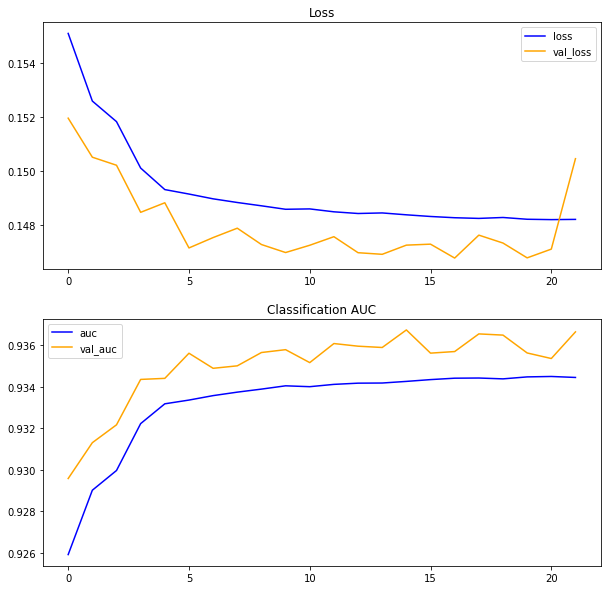

Accuracy: mean=15.046 std=0.000, n=1


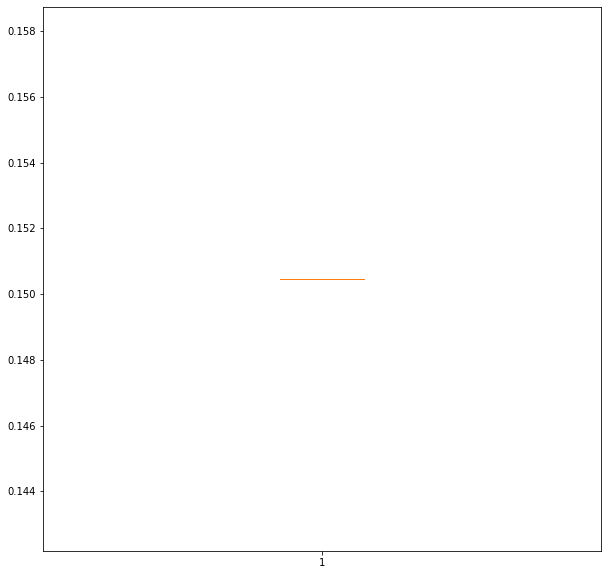

Scores:  [0.15046200156211853]


In [24]:
# learning curves
print(histories[0].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Build an ensamble of networks trained using k-folding and test it on test data

---



In [25]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #test data
  np_x_test_all = x_test_all.to_numpy()[0:100000]
  np_y_test_all = y_test_all.to_numpy()[0:100000]
  np_sw_test_all = sw_test_all.to_numpy()[0:100000]

  # normalize test data
  np_x_test_all = np.array(layer(np_x_test_all))


  # make predictions
  yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  # sum across ensembles
  summed = np.sum(yhats, axis=0)/len(models)
  
  # func to calculate auc

  fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all)

  m = tf.keras.metrics.AUC(num_thresholds=1000)
  m.update_state(np_y_test_all, summed, sample_weight=np_sw_test_all)
  r_auc = m.result().numpy()
  print("r_auc (ensamble) == ",r_auc)

  aucs = []
  for i in range(len(models)):
    yyhats = models[i].predict(np_x_test_all)[:,0]
    m.update_state(np_y_test_all, yyhats, sample_weight=np_sw_test_all)
    aucs.append(m.result().numpy())

  av_auc = np.mean(aucs)

  

  #plot roc
  plt.figure(figsize=(6,4))
  plt.plot(1-fpr,tpr)
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  summed = summed.reshape((len(summed),1))

  #print(np.ma.masked_where(np_y_test_all>0.5,summed))
  #print(np.ma.masked_where(np_y_test_all<0.5,summed))

  plt.figure(figsize=(6,4))
  plt.hist(np.ma.masked_where(np_y_test_all>0.5,summed), bins=200, label="Bckg.",log=True)
  plt.hist(np.ma.masked_where(np_y_test_all<0.5,summed), bins=200, label="Signal",log=True)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  return r_auc, av_auc, aucs

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200
r_auc (ensamble) ==  0.9538063


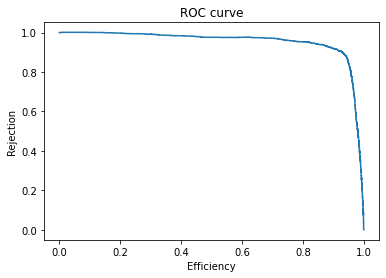

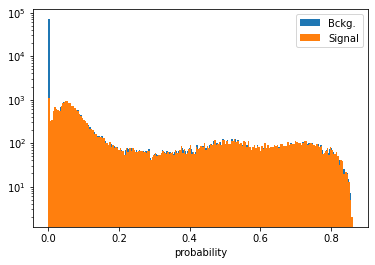

signal_mass =  250
r_auc (ensamble) ==  0.97608626


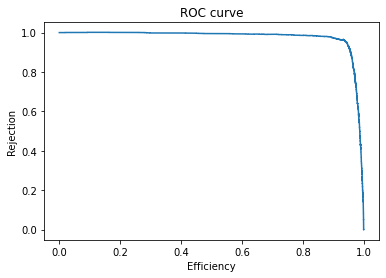

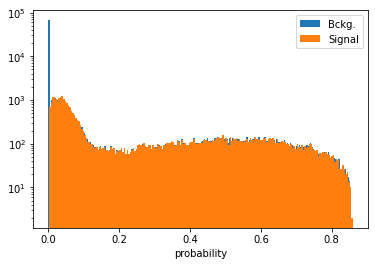

signal_mass =  300
r_auc (ensamble) ==  0.9843845


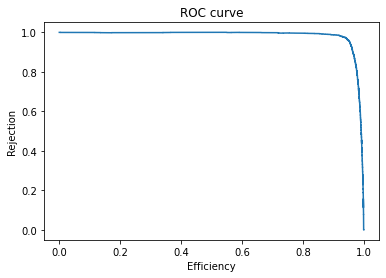

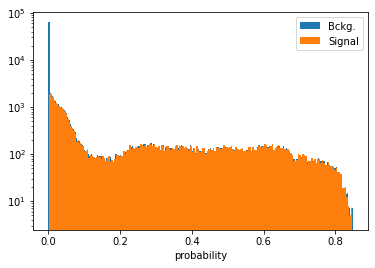

signal_mass =  350
r_auc (ensamble) ==  0.984823


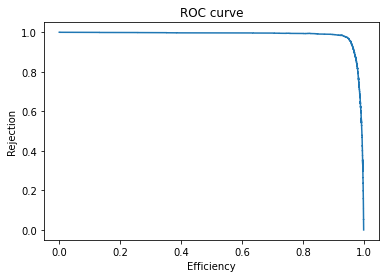

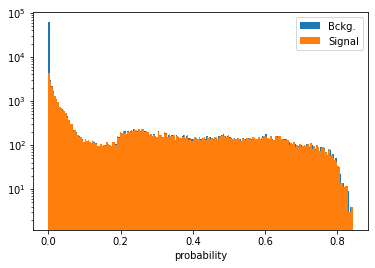

signal_mass =  400
r_auc (ensamble) ==  0.9886185


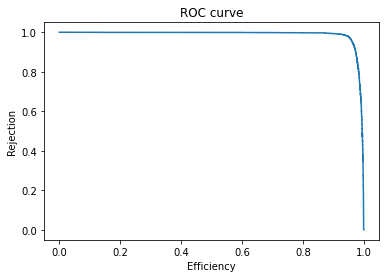

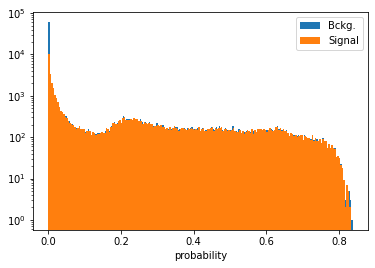

signal_mass =  500
r_auc (ensamble) ==  0.99265903


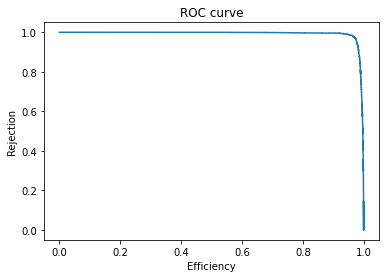

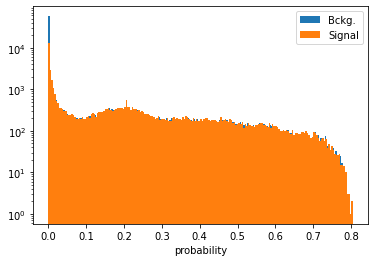

signal_mass =  600
r_auc (ensamble) ==  0.99488753


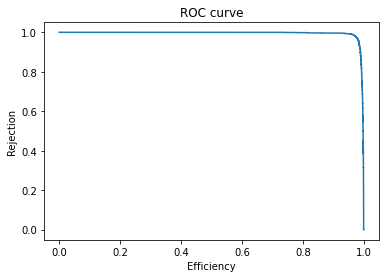

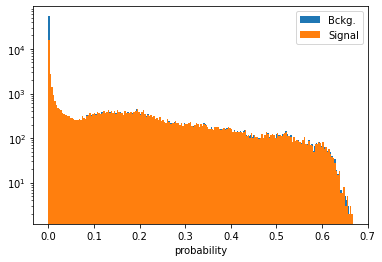

signal_mass =  700
r_auc (ensamble) ==  0.9956723


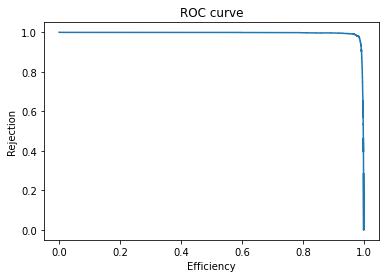

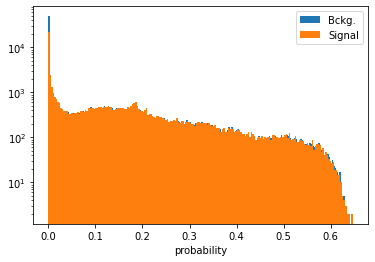

signal_mass =  800
r_auc (ensamble) ==  0.99705386


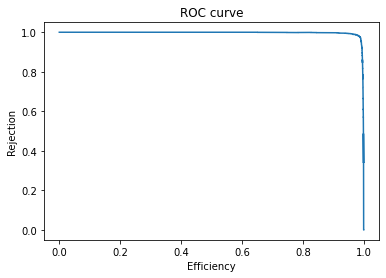

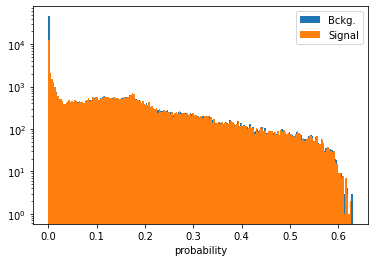

signal_mass =  1200
r_auc (ensamble) ==  0.998296


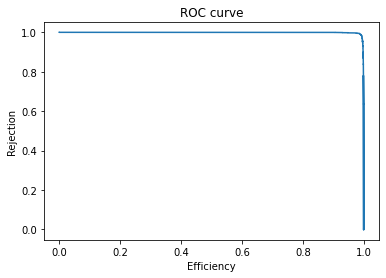

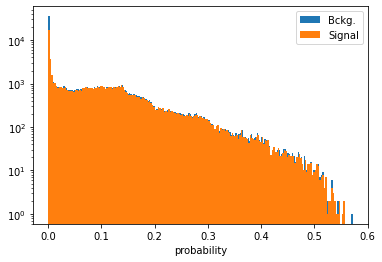

signal_mass =  1500
r_auc (ensamble) ==  0.99928725


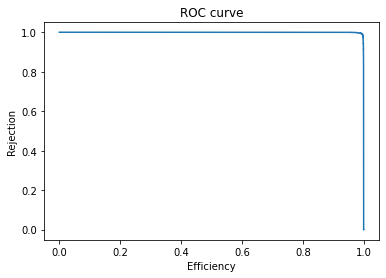

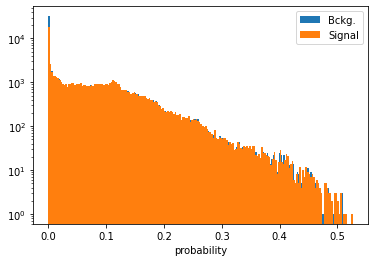

signal_mass =  2000
r_auc (ensamble) ==  0.9984928


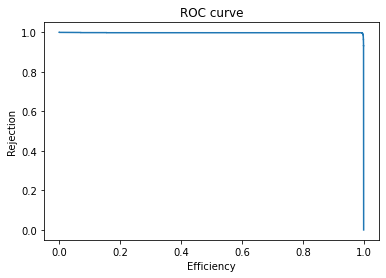

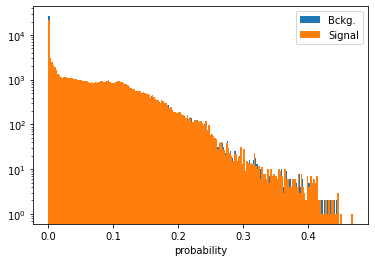

signal_mass =  2500
r_auc (ensamble) ==  1.0003173


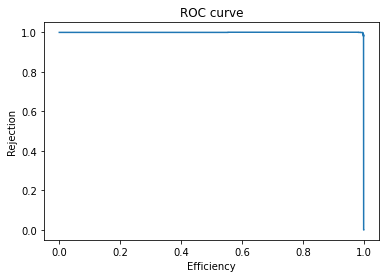

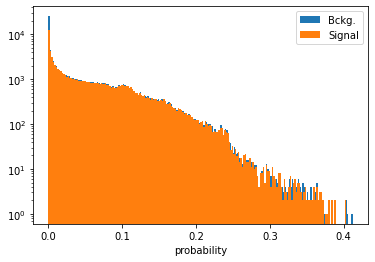

In [26]:
auc_list = []
av_auc_list = []
aucs_list = []

for m in masses:
  print("signal_mass = ",m)
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list.append(auc)
  av_auc_list.append(av_auc)
  aucs_list.append(aucs)

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

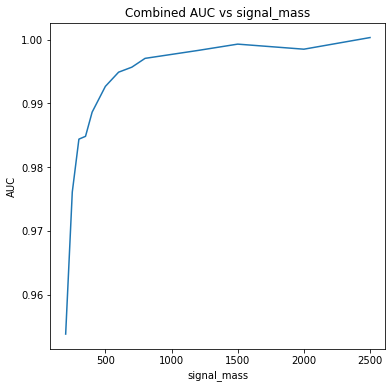

[0.9538063]


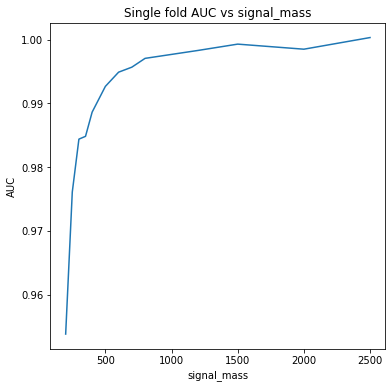

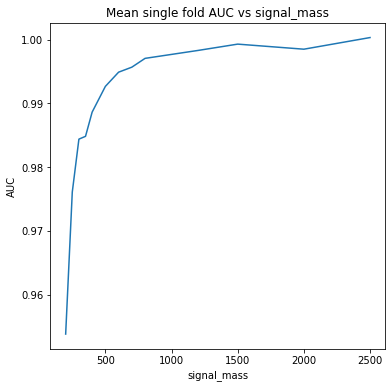

,signal_mass,comb. auc,mean auc
0,200,0.953806,0.953806
1,250,0.976086,0.976086
2,300,0.984384,0.984384
3,350,0.984823,0.984823
4,400,0.988618,0.988618
5,500,0.992659,0.992659
6,600,0.994888,0.994888
7,700,0.995672,0.995672
8,800,0.997054,0.997054
9,1200,0.998296,0.998296


In [27]:

plt.figure(figsize=(6,6))
plt.plot(masses, np.array(auc_list))
plt.title('Combined AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

print(aucs_list[0])

plt.figure(figsize=(6,6))
for i in range(len(aucs_list[0])):
  aux=[]
  for k in range(len(aucs_list)):
    aux.append(aucs_list[k][i])
  plt.plot(masses, np.array(aux))
plt.title('Single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(av_auc_list))
plt.title('Mean single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list)), 
               columns =['signal_mass', 'comb. auc', 'mean auc']) 
aucf

Stop program execution

In [28]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Split test data according to signal_mass, than train and test a network separately for each subsample. 

In [ ]:
auc_list_sep = []

for m in masses:
  print("signal_mass = ",m)

  #select events with a given signal_mass from the training dataset...
  mask = np.in1d(x_train_all.signal_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[1].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc_list_sep.append(test_ensamble(x_test_m, y_test_m, sw_test_m))

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

In [ ]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep)), 
               columns =['signal_mass', 'auc']) 
aucf